> df에서 사기거래가 한 번이라도 있었던 사람의 데이터만 모아서 학습시켜봄. 즉, 사기거래가 한번이라도 없던 사람의 데이터는 제거했다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
_df = pd.read_csv("fraudTrain.csv")

In [4]:
cus_list = set(_df.query('is_fraud==1').cc_num.tolist())
_df2 = _df.query("cc_num in @ cus_list")
_df2 = _df2.assign(time= list(map(lambda x: int(x.split(' ')[-1].split(':')[0]), _df2['trans_date_trans_time'])))

In [5]:
_df2.shape

(651430, 24)

In [6]:
_df2.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'time'],
      dtype='object')

In [7]:
_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651430 entries, 3 to 1048574
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             651430 non-null  int64  
 1   trans_date_trans_time  651430 non-null  object 
 2   cc_num                 651430 non-null  float64
 3   merchant               651430 non-null  object 
 4   category               651430 non-null  object 
 5   amt                    651430 non-null  float64
 6   first                  651430 non-null  object 
 7   last                   651430 non-null  object 
 8   gender                 651430 non-null  object 
 9   street                 651430 non-null  object 
 10  city                   651430 non-null  object 
 11  state                  651430 non-null  object 
 12  zip                    651430 non-null  int64  
 13  lat                    651430 non-null  float64
 14  long                   651430 non-n

In [8]:
_df2["is_fraud"].value_counts()

0    645424
1      6006
Name: is_fraud, dtype: int64

In [9]:
_df2["is_fraud"].value_counts()/len(_df2)

0    0.99078
1    0.00922
Name: is_fraud, dtype: float64

In [11]:
_df2.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,time
3,3,2019-01-01 0:01,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0
5,5,2019-01-01 0:04,4.767270e+15,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,...,-75.2045,2158,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.653382,-76.152667,0,0
6,6,2019-01-01 0:04,3.007470e+13,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,...,-100.9893,2691,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.162705,-100.153370,0,0
7,7,2019-01-01 0:05,6.011360e+15,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,...,-78.6003,6018,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.948089,-78.540296,0,0
8,8,2019-01-01 0:05,4.922710e+15,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,...,-79.6607,1472,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.351813,-79.958146,0,0


In [12]:
df = _df2

In [14]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In [15]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()+\
                                                      df["merchant"].values.tolist()))}
    
    df["from"]=df["cc_num"].apply(lambda x:mapping[x])  #엣지의 출발점
    df["to"]=df["merchant"].apply(lambda x:mapping[x])  #엣지의 도착점
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G, {(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")  #엣지 속성 설정,각 속성의 사기 여부부 
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") # 엣지 속성 설정, 각 엣지의 거래 금액

    return G

In [16]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                       df["cc_num"].values.tolist() +
                                                       df["merchant"].values.tolist()))}
    df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"]=df["merchant"].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    
    
    return G
    

In [17]:
G_bu = build_graph_bipartite(df, nx.Graph(name="Bipartite Undirect"))

In [18]:
G_tu = build_graph_tripartite(df, nx.Graph())

In [20]:
for G in [G_bu, G_tu]:
    print("nede:", nx.number_of_nodes(G))
for G in [G_bu, G_tu]:
    print("edge:",nx.number_of_edges(G))

nede: 1289
nede: 652719
edge: 268964
edge: 1302860


In [22]:
for G in [G_bu, G_tu]:
    print(nx.degree_pearson_correlation_coefficient(G))

-0.37874509971252246
-0.7222260615980979


In [23]:
import networkx as nx
import community

In [24]:
import community
for G in [G_bu, G_tu]:
    parts = community.best_partition(G, random_state=42, weight='weight')

In [25]:
communities = pd.Series(parts)

In [26]:
print(communities.value_counts().sort_values(ascending=False))

2      21225
34      9652
117     9362
3       8477
78      8384
       ...  
127      812
110      793
121      785
103      449
95       439
Length: 142, dtype: int64


<Axes: ylabel='Frequency'>

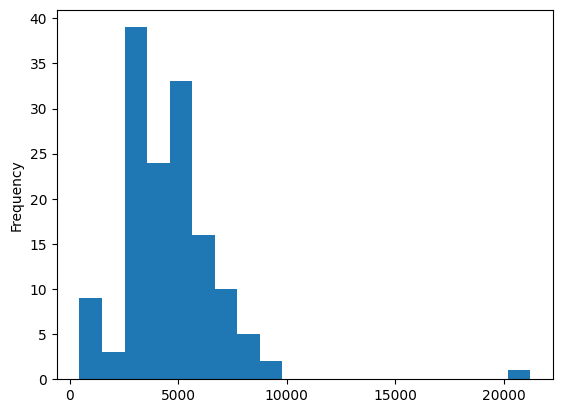

In [27]:
communities.value_counts().plot.hist(bins=20)

In [28]:
graphs = [] # 부분그래프 저장
d = {}  # 부정 거래 비율 저장 
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

99     2.549511
69     2.080000
4      1.996198
43     1.969697
133    1.871491
         ...   
127    0.246609
91     0.120192
104    0.115207
103    0.000000
121    0.000000
Length: 142, dtype: float64

In [30]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    6006
0    6006
Name: is_fraud, dtype: int64


In [31]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [32]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [33]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


In [34]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.5428571428571428
Recall: 0.016725352112676055
F1-Score: 0.032450896669513236
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.6840981856990395
Recall: 0.5642605633802817
F1-Score: 0.6184273999035215
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.45454545454545453
Recall: 0.022007042253521125
F1-Score: 0.041981528127623846
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.46296296296296297
Recall: 0.022007042253521125
F1-Score: 0.04201680672268907


오히려 f1score가 낮아졌다...